In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime as datetime
import datetime as dt

In [10]:
folder = '/Users/nam-yeong/Downloads/data'
files = os.listdir('/Users/nam-yeong/Downloads/data')

files[0]

path = os.path.join(folder,files[0])

df = pd.read_csv(path,encoding='utf-8')


In [16]:
df.head()

,Attributed Touch Type,Attributed Touch Time,Install Time,Event Time,Event Name,Event Value,Event Revenue,Event Revenue Currency,Event Revenue KRW,Cost Model,...,Retargeting Conversion Type,Is Primary Attribution,Attribution Lookback,Reengagement Window,Match Type,User Agent,HTTP Referrer,Original URL,Device Model,Store Product Page
0,click,2023-10-02 18:33:28,2023-10-02 18:38:00,2023-11-30 23:59:53,TC_benefit_list,"{""benefit_id"":""1""}",NaN,USD,NaN,NaN,...,NaN,False,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1335.0.3.4 Darw...,NaN,http://webjoin.balso.io/66rp/x2v4l1j5?remote-i...,iPhone7,NaN
1,click,NaN,2023-11-30 23:14:37,2023-11-30 23:59:52,TC_benefit_list,"{""benefit_id"":""9""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,srn,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,NaN,iPhoneSE3rdGen,NaN
2,click,2023-11-06 00:07:41,2023-11-06 00:08:46,2023-11-30 23:59:52,TC_benefit_list,"{""benefit_id"":""7""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,https://app.appsflyer.com/id1630747840?pid=adi...,iPhoneXSMax,NaN
3,click,NaN,2023-11-30 23:14:37,2023-11-30 23:59:48,TC_benefit_list,"{""benefit_id"":""1""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,srn,BalloSodeuk/23112401 CFNetwork/1485 Darwin/23.1.0,NaN,NaN,iPhoneSE3rdGen,NaN
4,click,2023-11-29 12:42:15,2023-11-29 12:42:36,2023-11-30 23:59:47,TC_benefit_list,"{""benefit_id"":""5""}",NaN,USD,NaN,NaN,...,NaN,True,7d,NaN,probabilistic,BalloSodeuk/23112401 CFNetwork/1399 Darwin/22.1.0,NaN,https://balso.onelink.me/g9qe/8ajtl4cr,iPhone13Pro,NaN


In [27]:
# df.groupby('AppsFlyer ID')[['Event Time']].count()

# df['Event Time'] = pd.to_datetime(df['Event Time'])
# df['datetime'] = df['Event Time'].dt.strftime('%Y-%m-%d')

df.datetime.unique()


array(['2023-11-30', '2023-11-29', '2023-11-28', '2023-11-27',
       '2023-11-26', '2023-11-25', '2023-11-24'], dtype=object)

### 하이퍼커넥트 생존분석 카피


In [30]:
import numpy as np
import pandas as pd

def generate_features(num_samples):
    genders = np.random.randint(0,2, num_samples)
    ages = np.random.gamma(15,1.6,num_samples).round()
    nums_friends = np.random.gamma(3,10,num_samples).round()
    nums_liked = np.random.gamma(5,30,num_samples).round()
    nums_calls = np.multiply(nums_friends, np.random.normal(15,2, num_samples).clip(1)).round()
    
    return pd.DataFrame({
        'gender' : genders,
        'age' : ages,
        'num_friends' : nums_friends,
        'num_liked' : nums_liked,
        'num_calls' : nums_calls
    })
    
def get_normal_prob(mean,stdev):
    return np.clip(np.random.normal(mean,stdev), 0.1,0.99)

def get_death_prob(t, features):
    zipped = pd.DataFrame({
        'gender' : features['gender'].apply(
            lambda x :
                get_normal_prob(0.9, 0.01) if x == 0
                else get_normal_prob(0.85, 0.01)
        ),
        'age' : features['age'].apply(
            lambda x : 
                ((0 <= x < 10 and get_normal_prob(0.7, 0.02)) or
                (10 <= x < 20 and get_normal_prob(0.85, 0.03)) or
                (20 <= x < 30 and get_normal_prob(0.9, 0.05)) or
                (30 <= x < 40 and get_normal_prob(0.75, 0.05)) or
                (40 <= x < 50 and get_normal_prob(0.7, 0.05)) or
                 get_normal_prob(0.2,0.05)) - np.random.normal(0.02 * np.log(t), 0.005)
        ),
        'num_friends' : features['num_friends'].apply(
            lambda x : np.clip(np.log(max(1,x)) * 0.2, 0.1, 0.99)
        ),
        'num_liked' : features['num_liked'].apply(
            lambda x : np.clip(np.log(max(1,x)) * (1/6), 0.1, 0.99)
        ),
        'num_calls' : features['num_calls'].apply(
            lambda x : np.clip(np.log(max(1,x)) * (1/8) + np.random.normal(0.03 * np.log(t),0.05),0.1, 0.99)
        )
        
    })
    
    return zipped['gender'] * 0.3 + zipped['age'] * 0.35 + zipped['num_friends'] * 0.05, zipped['num_liked'] * 0.05 + zipped['num_calls'] * 0.25

def generate_datasets(num_samples, death_trheshold, max_time):
    data = generate_features(num_samples)
    data['event'] = False
    data['time'] = 1
    time = 1
    
    while time < max_time:
        time = time + 1
        prob = get_death_prob(time, data)
        data['time'] = data['time'] + ~(data['event'] | (prob < death_trheshold)) * 1
        data['event'] = data['event'] | (prob > death_trheshold)
    
    return data

In [47]:
import numpy as np
import pandas as pd

def generate_features(num_samples):
    genders = np.random.randint(0, 2, num_samples)
    ages = np.random.gamma(15, 1.6, num_samples).round()
    nums_friends = np.random.gamma(3, 10, num_samples).round()
    nums_liked = np.random.gamma(5, 30, num_samples).round()
    nums_calls = np.multiply(nums_friends, np.random.normal(15, 2, num_samples).clip(1)).round()
    
    return pd.DataFrame({
        'gender': genders,
        'age': ages,
        'num_friends': nums_friends,
        'num_liked': nums_liked,
        'num_calls': nums_calls
    })

def get_normal_prob(mean, stdev):
    return np.clip(np.random.normal(mean, stdev), 0.1, 0.99)

def get_death_prob(t, features):
    zipped = pd.DataFrame({
        'gender': features['gender'].apply(
            lambda x:
                get_normal_prob(0.9, 0.01) if x == 0
                else get_normal_prob(0.85, 0.01)
        ),
        'age' : features['age'].apply(
            lambda x: ((0 <= x < 10 and get_normal_prob(0.7, 0.02)) or
                       (10 <= x < 20 and get_normal_prob(0.85, 0.03)) or
                       (20 <= x < 30 and get_normal_prob(0.9, 0.05)) or
                       (30 <= x < 40 and get_normal_prob(0.75, 0.05)) or
                       (40 <= x < 50 and get_normal_prob(0.7, 0.05)) or            
                       get_normal_prob(0.2, 0.05)) - np.random.normal(0.02 * np.log(t), 0.005)
        ),
        'num_friends': features['num_friends'].apply(
            lambda x: np.clip(np.log(max(1, x)) * 0.2, 0.1, 0.99)
        ),
        'num_liked': features['num_liked'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/6), 0.1, 0.99)
        ),
        'num_calls': features['num_calls'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/8) + np.random.normal(0.03 * np.log(t), 0.005), 0.1, 0.99)
        )
    })
    
    return zipped['gender'] * 0.3 + zipped['age'] * 0.35 + zipped['num_friends'] * 0.05 + zipped['num_liked'] * 0.05 + zipped['num_calls'] * 0.25

def generate_dataset(num_samples, death_threshold, max_time):
    data = generate_features(num_samples)
    data['event'] = False
    data['time'] = 1
    time = 1
    
    while time < max_time:
        time = time + 1
        prob = get_death_prob(time, data)
        
        # Update 'time' only for individuals who have not experienced the event
        data.loc[~data['event'], 'time'] = data['time'] + 1
        
        data['event'] = data['event'] | (prob < death_threshold)

    
    # while time < max_time:
    #     time = time + 1
    #     prob = get_death_prob(time, data)
    #     data['time'] = data['time'] + ~(data['event'] | (prob < death_threshold)) * 1
    #     data['event'] = data['event'] | (prob < death_threshold)

    return data
    


In [46]:
data


,gender,age,num_friends,num_liked,num_calls,event,time
0,1,19.0,74.0,162.0,1137.0,True,2
1,0,21.0,33.0,84.0,454.0,True,2
2,0,26.0,17.0,198.0,283.0,True,2
3,0,24.0,28.0,162.0,378.0,True,2
4,1,24.0,26.0,71.0,389.0,True,2
...,...,...,...,...,...,...,...
2995,1,17.0,24.0,164.0,392.0,True,2
2996,0,32.0,13.0,126.0,144.0,True,2
2997,1,34.0,24.0,150.0,369.0,True,2
2998,0,33.0,41.0,131.0,732.0,True,2


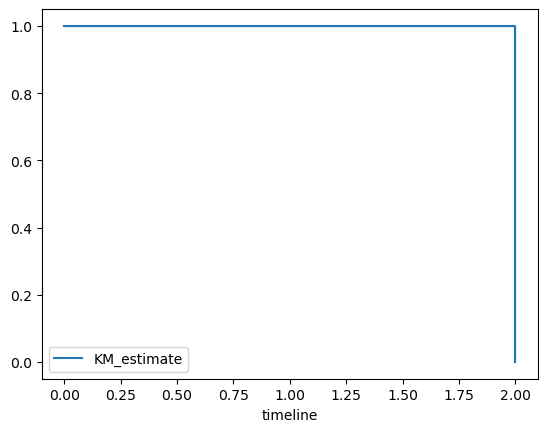

In [42]:

from lifelines import KaplanMeierFitter

data = generate_datasets(3000, 0.75, 500)

kmf = KaplanMeierFitter()
kmf.fit(data['time'], data['event'])

plot = kmf.plot_survival_function()



In [39]:
 data.time.value_counts()

time
2    2994
1       6
Name: count, dtype: int64